# **Emotion Recognition using Convolutional Neural Networks**

## Mount Google Drive

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part 1: Import Libraries

In [36]:
import io
import zipfile
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Part 2: Load and Preprocess the Data

## 1. Define Dataset Path and Extract Files

In [37]:
zip_file_path = "/content/drive/MyDrive/emotion.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    file_list = zip_ref.namelist()

total_images = len(file_list)
print(f"Total number of images in the dataset: {total_images}")

Total number of images in the dataset: 10867


## 2. Count Images per each label

In [38]:
label_counts = {}

for file_name in file_list:
    subfolder = file_name.split('/')[0]  # Extract subfolder name
    label_counts[subfolder] = label_counts.get(subfolder, 0) + 1

for subfolder, count in label_counts.items():
    print(f"{subfolder}: {count} images")

anger: 1185 images
contempt: 1002 images
disgust: 1026 images
fear: 1463 images
happy: 1501 images
neutral: 1560 images
sad: 1350 images
surprise: 1780 images


## 3. Define the maximum number of images to append for each label

In [39]:
dataset=[]
max_images_per_label = 1000

## 4. Resize the images and normalize pixel values

In [40]:
label_counts = {}

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_name in file_list:
        label = file_name.split('/')[0]

        if label_counts.get(label, 0) >= max_images_per_label:
            continue

        with zip_ref.open(file_name) as file:
            image_data = file.read()
            image = Image.open(io.BytesIO(image_data))
            image = image.resize((96, 96))  # Resize images to a consistent size
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

            dataset.append((image, label))

            label_counts[label] = label_counts.get(label, 0) + 1

            if label_counts[label] >= max_images_per_label:
                continue

## 5. Display Sample Images from Each Label

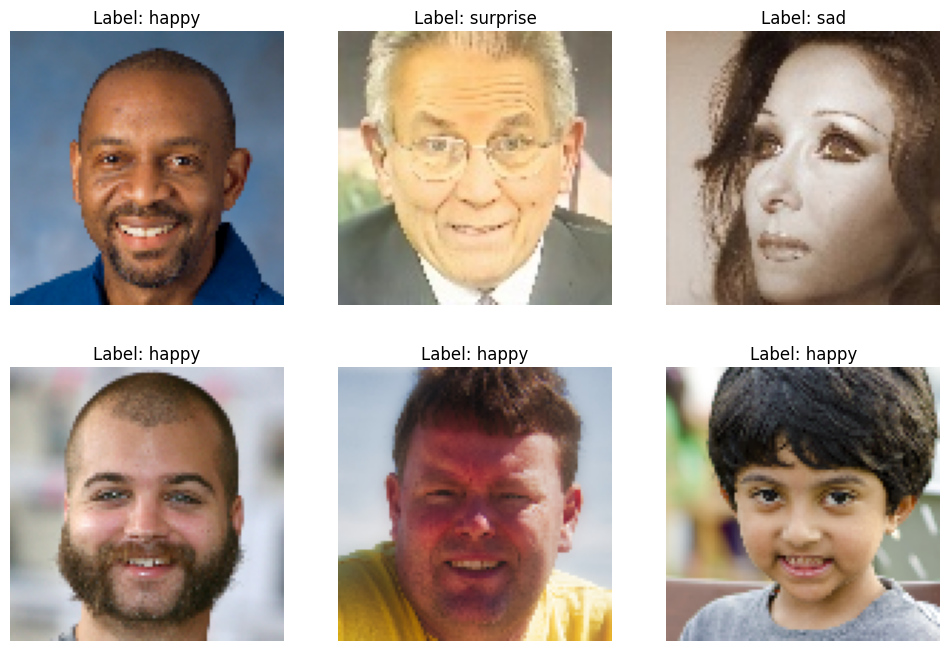

In [41]:
import matplotlib.pyplot as plt
import random

num_images_to_display = 6

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i in range(2):
    for j in range(3):
        index = random.randint(0, len(dataset) - 1)

        image, label = dataset[index]

        axes[i, j].imshow(image)
        axes[i, j].set_title(f"Label: {label}")
        axes[i, j].axis('off')

plt.show()

# Part 3: Split Data into Training and Testing Sets

## 1. Label Encoding and One-Hot Encoding

In [42]:
from keras.utils import to_categorical

X = [image for image, _ in dataset]
y = [label for _, label in dataset]
label_set=list(set(y))
label_to_index = {label: index for index, label in enumerate(label_set)}

index_to_label={value: key for key,value in label_to_index.items()}
print(index_to_label)

y = np.array([label_to_index[label] for label in y])

{0: 'contempt', 1: 'fear', 2: 'surprise', 3: 'anger', 4: 'sad', 5: 'neutral', 6: 'happy', 7: 'disgust'}


## 2. Extracting Features

In [43]:
X = np.array(X)
y = to_categorical(np.array(y), 8)

## 3. Data Splitting

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

# Part 4: Building the CNN model

## 1. Import Necessary Libraries

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import plot_model

## 2. Build the Sequential Model

In [46]:
model = Sequential()

## 3. Add Convolutional Layers with Batch Normalization, Pooling and Dropout

In [47]:

model.add(Conv2D(32, (3,3), activation="relu", input_shape=(96,96,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## 4. Flatten the output and add dense layers with batch normalization and dropout

In [48]:
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

## 5. Add the output layer with softmax activation for multi-class classification

In [49]:
model.add(Dense(8, activation='softmax'))

## 6. Compile the Model

In [50]:
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## 7. Model Summary

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_4 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 47, 47, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 45, 45, 64)       

## 8. Model Visualization

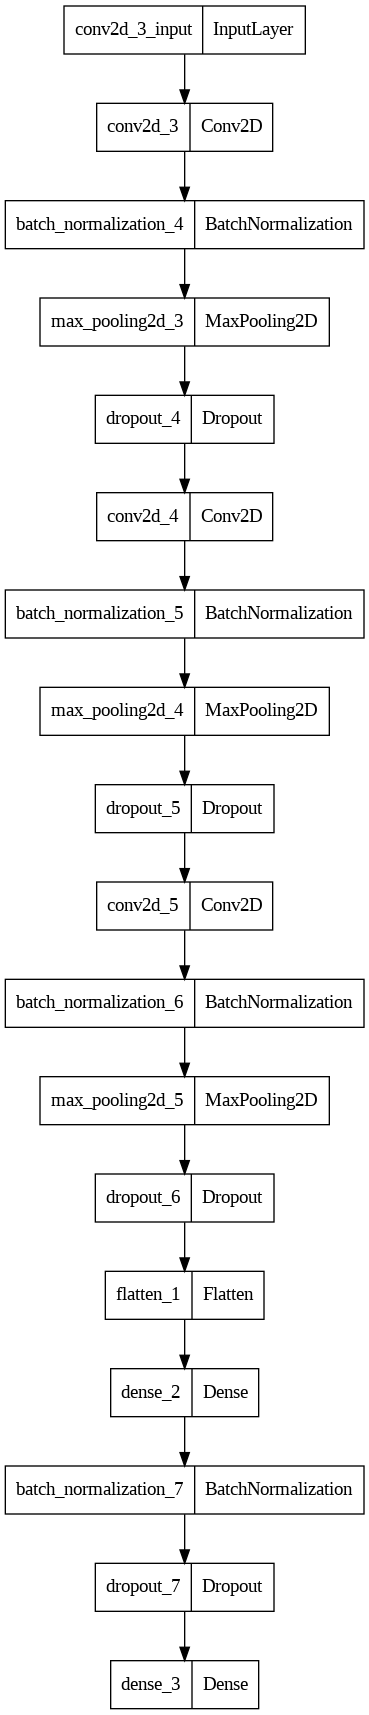

In [52]:
plot_model(model)

# Part 5: Train the CNN Model

## 1. Import and Define Callbacks

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(factor=0.2, patience=8, min_lr=0.00001, monitor='val_loss', mode='min')
]

## 2. Train the Model

In [54]:
history = model.fit(X_train,y_train,
                    epochs=35,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/35
175/175 [==============================] - 137s 767ms/step - loss: 6.4609 - accuracy: 0.2884 - val_loss: 13.5451 - val_accuracy: 0.1308 - lr: 0.0010
Epoch 2/35
175/175 [==============================] - 133s 762ms/step - loss: 4.4983 - accuracy: 0.3477 - val_loss: 4.2163 - val_accuracy: 0.2533 - lr: 0.0010
Epoch 3/35
175/175 [==============================] - 126s 723ms/step - loss: 3.3573 - accuracy: 0.4334 - val_loss: 3.3608 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 4/35
175/175 [==============================] - 126s 720ms/step - loss: 2.7787 - accuracy: 0.4807 - val_loss: 2.8235 - val_accuracy: 0.4067 - lr: 0.0010
Epoch 5/35
175/175 [==============================] - 133s 763ms/step - loss: 2.5637 - accuracy: 0.4955 - val_loss: 2.6720 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 6/35
175/175 [==============================] - 127s 724ms/step - loss: 2.5081 - accuracy: 0.5320 - val_loss: 2.7361 - val_accuracy: 0.4775 - lr: 0.0010
Epoch 7/35
175/175 [=========================

# Part 6: Model Evaluation and Visualization

## 1. Test Set Evaluation

In [55]:

test_loss, test_accuracy = model.evaluate(np.array(X_test), y_test)
print(f"Test accuracy: {test_accuracy}")

38/38 [==============================] - 6s 154ms/step - loss: 1.8858 - accuracy: 0.5975
Test accuracy: 0.5975000262260437


## 2.Display Sample Predictions

1/1 [==============================] - 0s 26ms/step


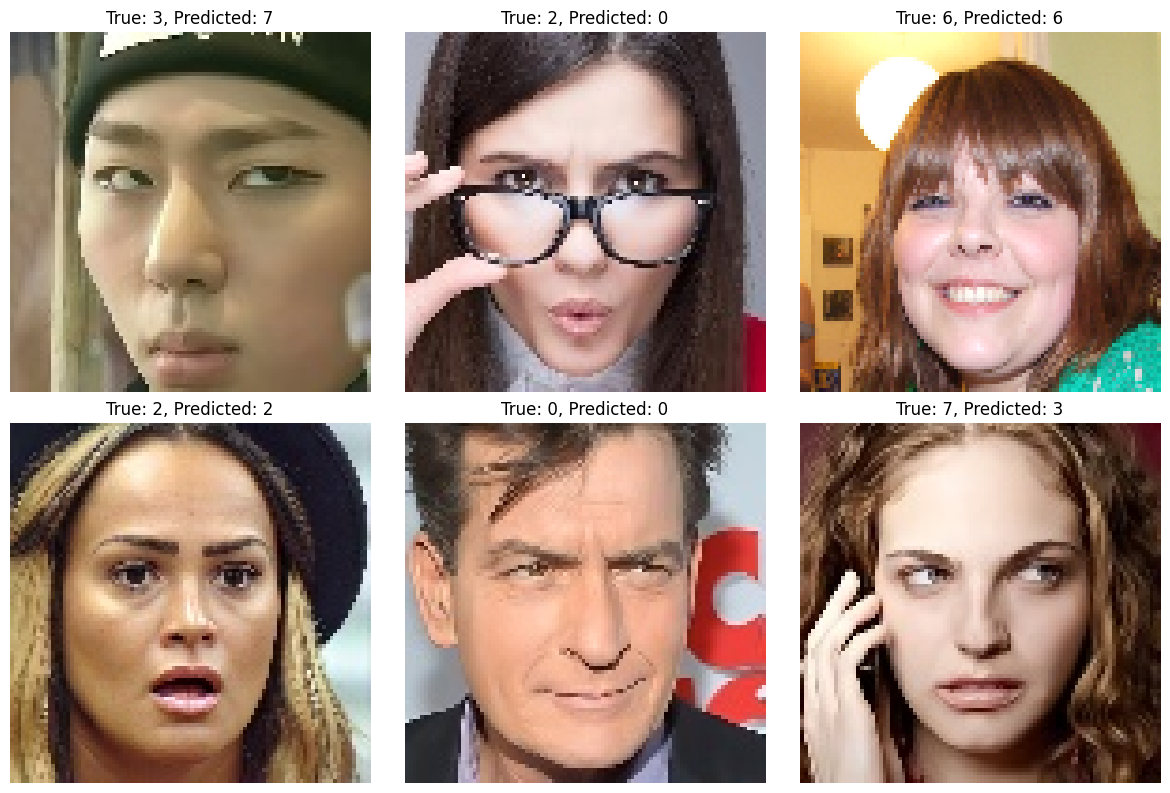

In [56]:
import matplotlib.pyplot as plt
import random

num_samples_to_display = 6

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

sample_indices = random.sample(range(len(X_test)), num_samples_to_display)

for i in range(2):
    for j in range(3):
        if len(sample_indices) > 0:
            index = sample_indices.pop(0)

            image = X_test[index]
            true_label = np.argmax(y_test[index])
            predicted_label = np.argmax(model.predict(np.expand_dims(image, axis=0)))

            axes[i, j].imshow(image)
            axes[i, j].set_title(f"True: {true_label}, Predicted: {predicted_label}")
            axes[i, j].axis('off')
        else:
            fig.delaxes(axes[i, j])

plt.tight_layout()
plt.show()

## 2. Plot Training and Validation Accuracy

In [57]:
import matplotlib.pyplot as plt

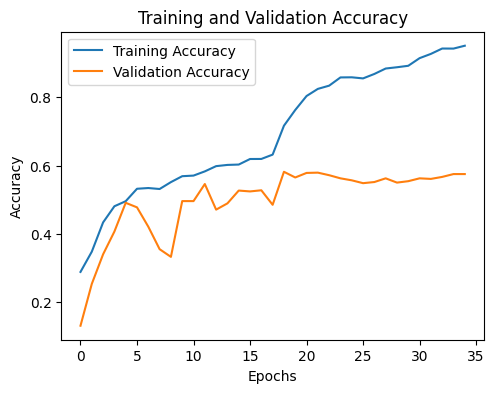

In [58]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

## 3. Plot Training and Validation Loss

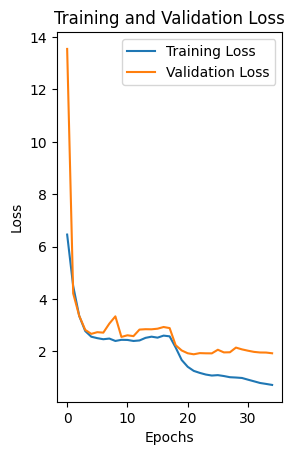

In [59]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## 4. Test Set Evaluation and Confusion Matrix Visualization

In [60]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

## 5. Make Predictions on the test data

In [61]:
y_pred = model.predict(X_test)

38/38 [==============================] - 6s 161ms/step


## 6. Display Confusion Matrix

Confusion Matrix:


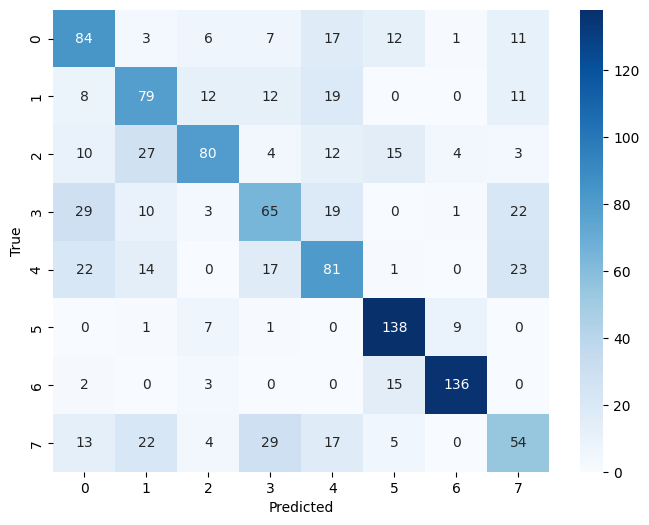

In [62]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_t=np.argmax(y_test, axis=1)

labels = [i for i in range(0,8)]
confusion = confusion_matrix(y_test_t, y_pred_labels, labels=labels)

print("Confusion Matrix:")


plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 7. Display Evaluation Metrics

In [63]:
accuracy = accuracy_score(y_test_t, y_pred_labels)
precision = precision_score(y_test_t, y_pred_labels, average='weighted')
recall = recall_score(y_test_t, y_pred_labels, average='weighted')
f1 = f1_score(y_test_t, y_pred_labels, average='weighted')


print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Test Accuracy: 0.5975
Precision: 0.5983243619802074
Recall: 0.5975
F1-Score: 0.5942587714449129


## 8. ROC Curve Analysis

### 8a: Import Necessary Libraries

In [64]:
from sklearn.metrics import roc_curve, auc
import numpy as np

### 8b: Initialize ROC Curve Data

In [65]:
fpr = []
tpr = []
roc_auc = []

### 8c: Make Predictions on the *Test* Data

In [66]:
y_pred_prob = model.predict(X_test)

38/38 [==============================] - 6s 168ms/step


### 8d: Calculate ROC Curve and AUC for Each Class

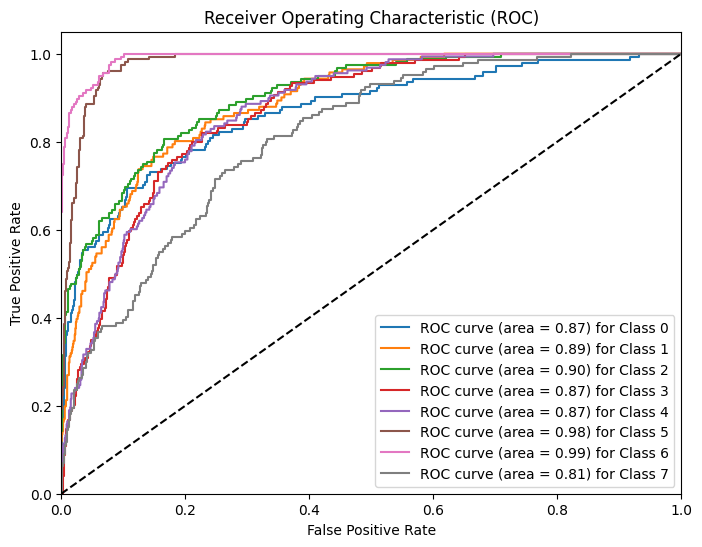

In [67]:
for i in range(len(labels)):
    fpr_i, tpr_i, _ = roc_curve(y_test_t == i, y_pred_prob[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)

    fpr.append(fpr_i)
    tpr.append(tpr_i)
    roc_auc.append(roc_auc_i)

plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for Class {labels[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Part 7: Model Testing on Sample Images

## 1. Image Selection and Preprocessing

In [68]:
import random
import numpy as np
import cv2

In [71]:
random_image = cv2.imread('/content/sample.png')

random_image = cv2.cvtColor(random_image, cv2.COLOR_RGB2BGR)

preprocessed_image = np.copy(random_image)

preprocessed_image = cv2.resize(preprocessed_image, (96, 96))
preprocessed_image = preprocessed_image / 255.0

## 2. Prediction and Display

1/1 [==============================] - 0s 28ms/step


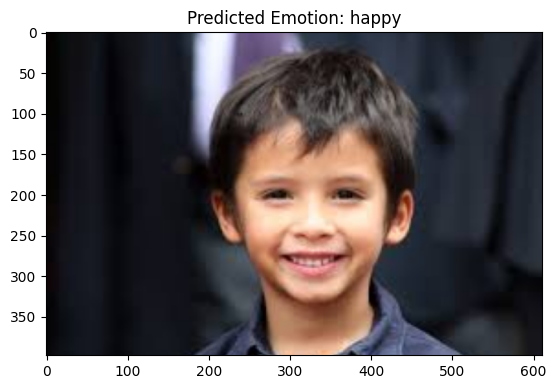

In [72]:
predicted_label_index = np.argmax(model.predict(np.expand_dims(preprocessed_image, axis=0)))

predicted_label = index_to_label[predicted_label_index]

plt.imshow(random_image)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.show()